In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import json

IMG_SIZE = 96
BATCH_SIZE = 16
EPOCHS = 50

In [33]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 4561 files belonging to 5 classes.
Using 3649 files for training.
Found 4561 files belonging to 5 classes.
Using 912 files for validation.


In [34]:
class_names = train_dataset.class_names
print("Classes:", class_names)

import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

AUTOTUNE = tf.data.AUTOTUNE

# -------------------------
# PREPROCESSING FUNCTION
# -------------------------
def preprocess(image, label):
    image = tf.image.central_crop(image, 0.8)          # Crop center
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize back to 96x96
    image = tf.cast(image, tf.float32) / 255.0        # Normalize
    return image, label


train_dataset = train_dataset.map(preprocess).prefetch(AUTOTUNE)
val_dataset = val_dataset.map(preprocess).prefetch(AUTOTUNE)

# -------------------------
# SAFE DATA AUGMENTATION
# -------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

Classes: ['down', 'idle', 'left', 'right', 'up']


In [35]:
model = models.Sequential([

    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    data_augmentation,

    # Block 1
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(5, activation='softmax')
])

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',

    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,454,725 (9.36 MB)

 Trainable params: 2,454,021 (9.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [37]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [38]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.5336 - loss: 1.2143 - val_accuracy: 0.1941 - val_loss: 2.1190 - learning_rate: 3.0000e-04
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.7038 - loss: 0.7796 - val_accuracy: 0.5954 - val_loss: 1.0180 - learning_rate: 3.0000e-04
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.7577 - loss: 0.6523 - val_accuracy: 0.8399 - val_loss: 0.4607 - learning_rate: 3.0000e-04
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.8010 - loss: 0.5423 - val_accuracy: 0.9189 - val_loss: 0.2916 - learning_rate: 3.0000e-04
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.8030 - loss: 0.5215 - val_accuracy: 0.9035 - val_loss: 0.2841 - learning_rate: 3.0000e-04
Epoch 6/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.8268 - loss: 0.4801 - val_accuracy: 0.9156 - val_loss: 0.2421 - learning_rate: 3.0000e-04
Epoch 7/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/ste

In [39]:
model.save("classifier.h5")
print("Model saved successfully!")

Model saved successfully!


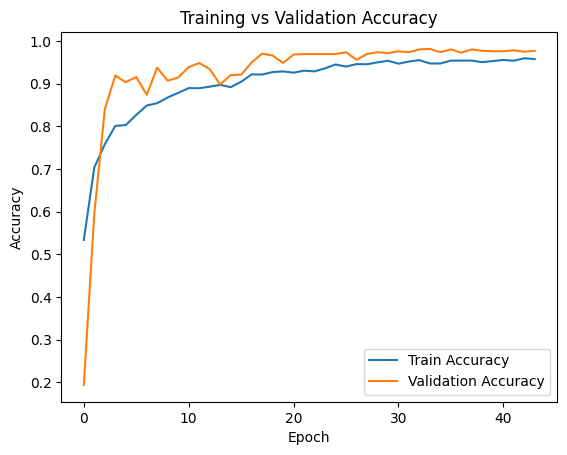

In [40]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()